### Setting ###

In [1]:
# Google Drive Mount
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Install foundation model - Segment Anything
#!pip install git+https://github.com/facebookresearch/segment-anything.git

In [3]:
# libraries
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import transforms

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

In [4]:
# device setting
device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

print(device)

cuda:1


In [5]:
# environment setting
batch_size = 4
epochs = 10
lr = 0.001
weight_decay = 0.0005
alpha = 0.8
gamma = 2

In [6]:
# directory setting
class ROOTDIR:
    image = "/home/kmk/COSE474Project/data/images/"
    mask = "/home/kmk/COSE474Project/data/masks/"

### Data example ###

In [7]:
images = sorted(glob.glob(ROOTDIR.image + "*.jpg"))
masks = sorted(glob.glob(ROOTDIR.mask + "*.jpg"))

In [8]:
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2)

In [9]:
val_images, test_images, val_masks, test_masks = train_test_split(val_images, val_masks, test_size=0.5)

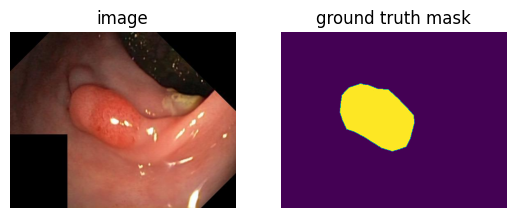

In [10]:
ex_img = Image.open(train_images[0]).convert("RGB")
ex_mask = Image.open(train_masks[0]).convert("L")

plt.subplot(1, 2, 1)
plt.imshow(ex_img)
plt.title("image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ex_mask)
plt.title("ground truth mask")
plt.axis("off")

plt.show()

### Zero shot prediction ###

In [11]:
# get bounding box
def get_bbox(true_mask):
    y_indices, x_indices = np.where(true_mask > 0)
    
    h, w = true_mask.shape
    
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    
    x_min = max(0, x_min - np.random.randint(0, 5))
    x_max = min(w, x_max + np.random.randint(0, 5))
    y_min = max(0, y_min - np.random.randint(0, 5))
    y_max = min(h, y_max + np.random.randint(0, 5))
    
    bbox = np.array([x_min, y_min, x_max, y_max])
    
    return bbox

In [12]:
# show bounding box
def show_bbox(bbox):
    color = "blue"
    
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    
    rect = patches.Rectangle((bbox[0], bbox[1]), w, h, edgecolor=color, facecolor=(0,0,0,0))
    
    ax = plt.gca()
    ax.add_patch(rect)

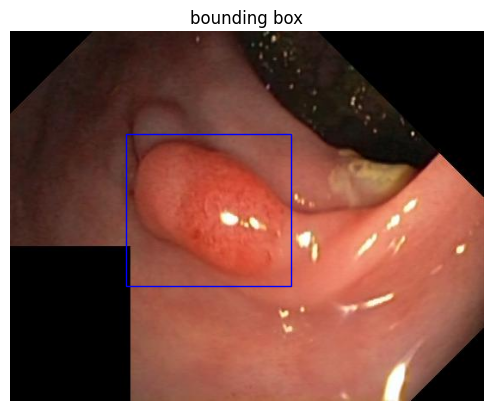

In [13]:
fig, axes = plt.subplots()

axes.imshow(np.array(ex_img))
show_bbox(get_bbox(np.array(ex_mask)))
axes.set_title("bounding box")
axes.axis("off")
plt.show()

In [14]:
# SAM model
model_type = "vit_h"
sam_checkpoint = "/home/kmk/COSE474Project/sam_vit_h_4b8939.pth"
# automatic mask generator
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
predictor.set_image(np.array(ex_img))
masks, _, _ = predictor.predict(point_coords=None, point_labels=None, box=get_bbox(np.array(ex_mask)),
                                multimask_output=False)

In [15]:
def show_mask(mask):
    ax = plt.gca()
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

(-0.5, 550.5, 429.5, -0.5)

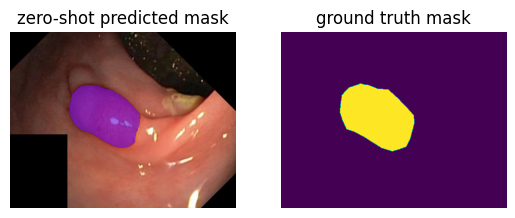

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(ex_img)
show_mask(masks)
plt.title("zero-shot predicted mask")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ex_mask)
plt.title("ground truth mask")
plt.axis("off")

### Prepare Dataset ###

In [17]:
# Dataset
class MedDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

    # img list 길이
    def __len__(self):
        return len(self.img_dir)

    # get image, label
    def __getitem__(self, idx):
        img = self.img_dir[idx]
        mask = self.mask_dir[idx]
        
        img = Image.open(img).convert("RGB")
        mask = Image.open(mask).convert("L")
        
        # get bounding box
        prompt = get_bbox(np.array(mask))
        
        if self.transform:
            image = self.transform(image=img, mask=mask, bboxes=prompt)["image"]
            label = self.transform(image=img, mask=mask, bboxes=prompt)["mask"]
            bbox = self.transform(image=img, mask=mask, bboxes=prompt)["bbox"]
        
        return image, label, bbox

In [18]:
# Image preprocess for SAM
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size)
        self.to_tensor = transforms.ToTensorV2()
    
    def __call__(self, image, mask, bboxes):
        image = np.array(image)
        mask = np.array(mask)
        
        h1, w1, _ = image.shape
        image = self.transform.apply_image(image)
        mask = torch.tensor(self.transform.apply_image(mask))
        
        _, h2, w2 = image.shape
        max_dim = max(h2, w2)
        pad_w = (max_dim - w2) // 2
        pad_h = (max_dim - h2) // 2
        
        padding = (pad_w, pad_h, max_dim - w2 - pad_w, max_dim - h2 - pad_h)
        image = transforms.Pad(padding)(image)
        mask = transforms.Pad(padding)(mask)
        
        bbox = self.transform.apply_boxes(bboxes, (h1, w1))
        bbox = [bbox[0] + pad_w, bbox[1] + pad_h, bbox[2] + pad_w, bbox[3] + pad_h]
        
        return image, mask, bbox

In [19]:
transform = ResizeAndPad(1024)
train_data = MedDataset(img_dir=train_images, mask_dir=train_masks, transform=transform)
val_data = MedDataset(img_dir=val_images, mask_dir=val_masks, transform=transform)
test_data = MedDataset(img_dir=test_images, mask_dir=test_masks, transform=transform)

In [20]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

### Training ###

In [21]:
# Calculate Focal Loss
class FocalLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, targets):
        inputs = inputs.flatten()
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE
        return focal_loss

# Calculate Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = inputs.flatten(0, 2)
        intersection = (inputs * targets).sum()
        dice = (2, * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

In [22]:
def criterion(x, y):
    focal, dice = FocalLoss(), DiceLoss()
    
    y = y.to(device)
    x = x.to(device)
    
    return 20*focal(x, y) + dice(x, y)

In [23]:
def train_model(model, trainloader, optimizer, writer, i):
    train_running_loss = 0.0
    
    model.to(device)
    model.train()
    
    for j, (image, masks, bbox) in enumerate(tqdm(trainloader)):
        image = image.to(device)
        mask = masks.to(device)
        bbox = bbox.to(device)
            
        y_pred = model(image, bbox, multimask_output=False)
        y_pred = y_pred.pred_masks.squeeze(1)
        
        optimizer.zero_grad()
        
        loss = criterion(y_pred, mask)
        
        writer.add_scalar("Loss/train", loss, j+i*len(trainloader))
        train_running_loss += loss.item()*batch_size
        
        loss.backward()
            
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    
    return train_loss

In [24]:
def val_model(model, valloader, writer, i):
    model.to(device)
    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for j, (image, masks, bbox) in enumerate(tqdm(valloader)):
            image = image.to(device)
            mask = masks.to(device)
            bbox = bbox.to(device)
            
            y_pred = model(image, bbox, multimaks_output=False)
            
            loss = criterion(y_pred, mask)
            
            writer.add_scalar("Loss/val", loss, j+i*len(valloader))
            
            val_running_loss += loss.item() * batch_size
            
        val_loss = val_running_loss / (j+1)
        
        return val_loss

In [25]:
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0, trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.trace_func = trace_func
        
        self.counter = 0
        self.val_loss = None
        self.val_loss_min = np.Inf
        self.early_stop = False
        
    def __call__(self, val_loss, model, file_name):
        if self.val_loss is None:
            self.val_loss = val_loss
            self.save_checkpoint(val_loss, model, file_name)
        elif val_loss > self.val_loss + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.val_loss = val_loss
            self.save_checkpoint(val_loss, model, file_name)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model, file_name):
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.4f} --> {self.val_loss:.4f}).")
            self.trace_func("Saving model...")
        torch.save(model.state_dict(), file_name)
        self.val_loss_min = val_loss

In [26]:
model = sam_model_registry[model_type](checkpoint=sam_checkpoint)

for param in model.image_encoder.parameters():
    param.requires_grad = False
    
for param in model.prompt_encoder.parameters():
    param.requires_grad = False
    
optimizer = optim.Adam(model.mask_decoder.parameters(), lr=lr, weight_decay=weight_decay)
es = EarlyStopping(patience=20, verbose=False, delta=0)
writer = SummaryWriter()

In [27]:
train_losses = []
val_losses = []

for i in tqdm(range(epochs)):
    train_loss = train_model(model=model, trainloader=train_dataloader, optimizer=optimizer, writer=writer, i=i)
    val_loss = val_model(model=model, valloader=val_dataloader, writer=writer, i=i)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    
    TRAINED_MODEL = f"/home/kmk/COSE474Project/checkpoint/segmentation_{i}_epoch.pth"
    
    es(val_loss, model, TRAINED_MODEL)
    
    if es.early_stop:
        writer.close()
        break

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

AttributeError: module 'albumentations.pytorch.transforms' has no attribute 'Pad'